In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../models'))
sys.path.append(os.path.abspath('../dataset_generation'))
# sys.path.append('..')
# sys.path.append('../models')
from NN_TopOpt import FeatureMappingDecSDF, FeatureMappingTopOpt, SIMP_basic
from TopOpt import TopOptimizer2D
import yaml

methods = {
    "fm_nn_heaviside": FeatureMappingTopOpt,
}

    # save the metrics to a json file
import json
import torch
   
def serialize_tensor(o):
    if isinstance(o, torch.Tensor):
        return o.item() if o.numel() == 1 else o.tolist()
    raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")

real_task_names = {
    "MBB_beam_half": "MBB beam half",
    "Cant_beam": "Cantilever beam",
    "Cant_beam_distrL": "Beam Distributed Load",
    "Brecket": "Bracket",
}


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def plot_metrics(metrics, task_dir, task_name,
                 num_experiments_per_plot=3,
                 x_axis_scale=5,
                 y_axis_scale=1.4):
    
    num_experiments = len(metrics["filename"])
    gamma_ks_list = metrics["gamma_ks"]
    plot_scale = 2

    # Split experiments into chunks with a maximum length of num_experiments_per_plot
    for start_idx in range(0, num_experiments, num_experiments_per_plot):
        end_idx = min(start_idx + num_experiments_per_plot, num_experiments)
        current_chunk = end_idx - start_idx

        # Create a new figure for the current chunk.
        fig, axes = plt.subplots(
            current_chunk, 2,
            figsize=(x_axis_scale * plot_scale, y_axis_scale * current_chunk * plot_scale),
            gridspec_kw={'width_ratios': [3, 1]}
        )
        # Ensure axes is 2D even if there is only one experiment in the chunk.
        if current_chunk == 1:
            axes = np.array([axes])
        
        for idx in range(current_chunk):
            global_idx = start_idx + idx
            
            # Left column: load and display the image from the corresponding filename.
            ax_img = axes[idx, 0]
            img = mpimg.imread(metrics["filename"][global_idx])
            ax_img.imshow(img)
            ax_img.axis('off')
            
            # Right column: display metric values with gamma_ks as the title.
            ax_text = axes[idx, 1]
            metric_text = (
                f"$\\mathbf{{Gamma\\_KS}}$: {gamma_ks_list[global_idx]}\n"
                f"\n"
                f"vf: {metrics['vf'][global_idx]:.3f}\n"
                f"compliance: {metrics['compliance'][global_idx]:.5f}\n"
                f"max_stress: {metrics['max_stress'][global_idx]:.3f}\n"
                f"H_min: {metrics['H_min'][global_idx]:.5f}\n"
                f"H_max: {metrics['H_max'][global_idx]:.5f}"
            )
            ax_text.text(0.25, 0.5, metric_text, ha='left', va='center', fontsize=10)
            ax_text.axis('off')
        
        # Set a suptitle for the current chunk showing its gamma values.
        gamma_values_str = ", ".join([f"{gamma}" for gamma in gamma_ks_list[start_idx:end_idx]])
        # fig.suptitle(f"{task_name} | Gamma KS Test \n Gamma values: {gamma_values_str}", fontsize=14, y=1.02)
        
        plt.tight_layout(pad=0.1, w_pad=0.0, h_pad=0.1)
        # print(start_idx, end_idx, gamma_ks_list)
        plt.savefig(f"{task_dir}/gamma_ks_{gamma_ks_list[start_idx]}_{gamma_ks_list[end_idx-1]}.png", dpi=300, bbox_inches='tight')
        plt.show()

def plot_metrics_markdown(metrics, real_task_name):
    """
    Generate and display a markdown table of the metrics with gamma_ks values as column headers.
    
    Parameters:
        metrics (dict): Dictionary containing metrics lists. Expected keys are:
            - 'gamma_ks': list of gamma_ks values
            - 'vf': list of volume fraction values
            - 'compliance': list of compliance values
            - 'max_stress': list of maximum stress values
            - 'H_min': list of H_min values
            - 'H_max': list of H_max values
    
    The generated markdown table will have a column for each gamma_ks value.
    """
    # Retrieve gamma_ks for header generation.
    gamma_ks = metrics.get("gamma_ks", [])
    # Create the header with "Metric" as the first column followed by each gamma_ks
    header = "$\\gamma_{ks}$ | " + " | ".join(str(g) for g in gamma_ks)
    # Create the separator line required for markdown tables.
    separator = "----- | " + " | ".join(["-----"] * len(gamma_ks))
    
    # Helper function to create a row for a given metric.
    def format_row(metric_name, values, fmt):
        formatted_values = [fmt.format(val) for val in values]
        return f"{metric_name} | " + " | ".join(formatted_values)
    
    # Create rows for relevant metrics with appropriate formatting.
    row_vf = format_row("vf", metrics.get("vf", []), "{:.3f}")
    compliance_vals = metrics.get("compliance", [])
    fmt_compliance = "{:.5f}"
    best_compliance = min(compliance_vals) if compliance_vals else None
    formatted_compliance = [
        f"**{fmt_compliance.format(val)}**" if best_compliance is not None and val == best_compliance else fmt_compliance.format(val)
        for val in compliance_vals
    ]
    row_compliance = "C | " + " | ".join(formatted_compliance)
    
    max_stress_vals = metrics.get("max_stress", [])
    fmt_max_stress = "{:.3f}"
    best_max_stress = min(max_stress_vals) if max_stress_vals else None
    formatted_max_stress = [
        f"**{fmt_max_stress.format(val)}**" if best_max_stress is not None and val == best_max_stress else fmt_max_stress.format(val)
        for val in max_stress_vals
    ]
    row_max_stress = "$VonMises_{max}$ | " + " | ".join(formatted_max_stress)
    row_H_min = format_row("$\min(\\rho)$", metrics.get("H_min", []), "{:.5f}")
    row_H_max = format_row("$\max(\\rho)$", metrics.get("H_max", []), "{:.5f}")
    
    # Assemble the markdown table.
    md_table = "\n".join([header, separator, row_vf, row_compliance, row_max_stress, row_H_min, row_H_max])
    
    # Attempt to display using IPython's Markdown display; fallback to print.
    # try:
    #     from IPython.display import Markdown, display
    #     display(Markdown(md_table))
    # except ImportError:
    print(md_table)
    print("\n")
    gmks_symbol = "$\\gamma_{ks}$"
    print(f'Table: experiments with different {gmks_symbol} values for {real_task_name}')



<>:108: SyntaxWarning: invalid escape sequence '\m'
<>:109: SyntaxWarning: invalid escape sequence '\m'
<>:108: SyntaxWarning: invalid escape sequence '\m'
<>:109: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_28981/4199238922.py:108: SyntaxWarning: invalid escape sequence '\m'
  row_H_min = format_row("$\min(\\rho)$", metrics.get("H_min", []), "{:.5f}")
/tmp/ipykernel_28981/4199238922.py:109: SyntaxWarning: invalid escape sequence '\m'
  row_H_max = format_row("$\max(\\rho)$", metrics.get("H_max", []), "{:.5f}")


In [3]:
config_name = "MBB_beam_half" #
# config_name = "Cant_beam"
# config_name = "Cant_beam_distrL"
# config_name = "Brecket"

task_name = "Beam"
# task_name = "Cantilever Beam"
# task_name = "Distributed Load Beam"
# task_name = "LBrecket"

root_dir = "../src/gamma_ks_test"
task_dir = f"{root_dir}/{config_name}"

metrics = json.load(open(f"{task_dir}/metrics.json"))

plot_metrics_markdown(metrics, real_task_names[config_name])

$\gamma_{ks}$ | 10 | 20 | 30 | 40 | 50 | 60 | 70 | 80
----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | -----
vf | 0.454 | 0.471 | 0.487 | 0.437 | 0.510 | 0.460 | 0.451 | 0.465
C | 0.00182 | 0.00169 | 0.00151 | 0.00163 | **0.00141** | 0.00155 | 0.00156 | 0.00153
$VonMises_{max}$ | 0.750 | 0.552 | 0.519 | 0.522 | 0.505 | 0.593 | 0.522 | **0.497**
$\min(\rho)$ | 0.06997 | 0.03533 | 0.02378 | 0.01800 | 0.01454 | 0.01223 | 0.01058 | 0.00934
$\max(\rho)$ | 0.93014 | 0.96479 | 0.97634 | 0.98212 | 0.98559 | 0.98790 | 0.98955 | 0.99078


Table: experiments with different $\gamma_{ks}$ values for MBB beam half


In [6]:
# config_name = "MBB_beam_half" #
# config_name = "Cant_beam"
# config_name = "Cant_beam_distrL"
config_name = "Brecket"

task_name = "Beam"
# task_name = "Cantilever Beam"
# task_name = "Distributed Load Beam"
# task_name = "LBrecket"

root_dir = "../src/gamma_ks_test"
task_dir = f"{root_dir}/{config_name}"

metrics = json.load(open(f"{task_dir}/metrics.json"))

plot_metrics_markdown(metrics)

Metric | 10 | 20 | 30 | 40 | 50 | 60 | 70 | 80
----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | -----
vf | 0.373 | 0.358 | 0.347 | 0.355 | 0.347 | 0.344 | 0.357 | 0.354
compliance | 0.00238 | 0.00212 | 0.00209 | 0.00207 | 0.00210 | 0.00213 | 0.00203 | **0.00198**
max_stress | 0.632 | **0.406** | 0.511 | 0.746 | 0.881 | 0.900 | 0.571 | 0.581
H_min | 0.00067 | 0.00105 | 0.00504 | 0.00089 | 0.00116 | 0.00163 | 0.00623 | 0.00103
H_max | 0.87418 | 0.93682 | 0.95769 | 0.96813 | 0.97439 | 0.97857 | 0.98155 | 0.98379

In [3]:
import torch 
torch.cuda.empty_cache()

# select the experiment directory
# experiment_dir = "../configs/NN_top_optimization/FM_NN_Heaviside/AE_DeepSDF"
experiment_dir = "../configs/NN_top_optimization/FM_NN_Heaviside/VAE_DeepSDF"
# experiment_dir = "../configs/NN_top_optimization/FM_NN_Heaviside/MMD_VAE_DeepSDF"

# config_name = "MBB_beam_half_fm_ae_hv" #
# config_name = "Cant_beam_half_fm_ae_hv"
# config_name = "Cant_beam_distrL_fm_ae_hv"
# config_name = "Brecket_fm_ae_hv"


# gamma_ks_list = [10]
# gamma_ks_list = [2, 5, 7, 10] #, 20, 30, 40, 60, 80]
gamma_ks_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# gamma_ks_list = [7, 30, 80]

In [4]:
def gamma_ks_experiment(gamma_ks, methods, params, src_dir='../src/gamma_ks_test'):
    params['ks_smooth_factor'] = gamma_ks
    TopOptimizer = TopOptimizer2D(methods, params)
    TopOptimizer.optimize(plot_interval=20)
    vf, compliance, max_stress = TopOptimizer.print_metrics()

    geometry_features = TopOptimizer.method.gaussian_core.get_geometry()
    H_min = TopOptimizer.method.gaussian_core.H_min
    H_max = TopOptimizer.method.gaussian_core.H_max

    # kernel_min = TopOptimizer.method.gaussian_core.kernel_min
    # kernel_max = TopOptimizer.method.gaussian_core.kernel_max

    # print(f"Kernel min: {kernel_min}, Kernel max: {kernel_max}")

    filename = f'{src_dir}/gamma_ks_{gamma_ks}.png'
    TopOptimizer.plot_final_result(geometry_features, filename=filename, plot_von_mises=True)

    return vf, compliance, max_stress, filename, H_min, H_max


def gamma_ks_experiment_cycle(methods, config_name, gamma_ks_list):
    config_path = f"{experiment_dir}/{config_name}.yaml"

    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)

    params = config['params']
    params['refactoring_markers'] = list(range(38, 80, 5))

    root_dir = "../src/gamma_ks_test"
    os.makedirs(root_dir, exist_ok=True)

    task_dir = f"{root_dir}/{config_name}"
    os.makedirs(task_dir, exist_ok=True)

    if not os.path.exists(f"{task_dir}/metrics.json"):
        metrics = {
            "gamma_ks": [],
            "vf": [],
            "compliance": [],
            "max_stress": [],
            "H_min": [],
            "H_max": [],
            "filename": [],
        }
    else:
        metrics = json.load(open(f"{task_dir}/metrics.json"))


    for gamma_ks in gamma_ks_list:
        if gamma_ks in metrics["gamma_ks"]:
            continue
        vf, compliance, max_stress, filename, H_min, H_max = gamma_ks_experiment(gamma_ks, methods, params, task_dir)

        metrics["gamma_ks"].append(gamma_ks)
        metrics["vf"].append(vf)
        metrics["compliance"].append(compliance)
        metrics["max_stress"].append(max_stress)
        metrics["H_min"].append(H_min)
        metrics["H_max"].append(H_max)
        metrics["filename"].append(filename)


        with open(f"{task_dir}/metrics.json", "w") as file:
            json.dump(metrics, file, default=serialize_tensor)

    # break


In [ ]:
# config_name = "MBB_beam_half_fm_ae_hv" #

# config_name = "Cant_beam_half_fm_ae_hv"
# task_name = "Cantilever Beam"

# config_name = "Brecket_fm_ae_hv"
# task_name = "LBrecket"

# config_name = "Cant_beam_distrL_fm_ae_hv"
# task_name = "Distributed Load Beam"

config_name = "MBB_beam_half" #
# config_name = "Cant_beam"
# config_name = "Cant_beam_distrL"
# config_name = "Brecket"

gamma_ks_experiment_cycle(methods, config_name, gamma_ks_list)

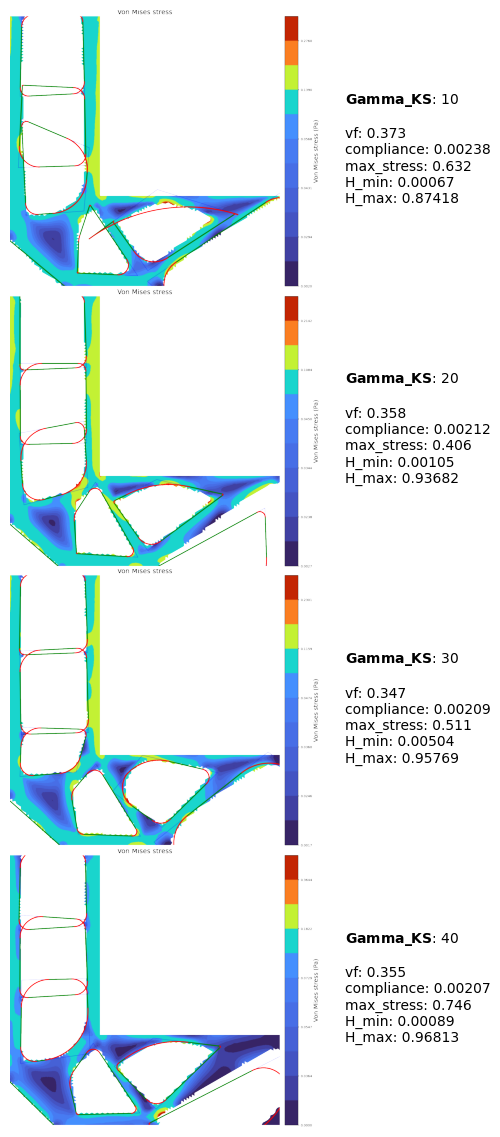

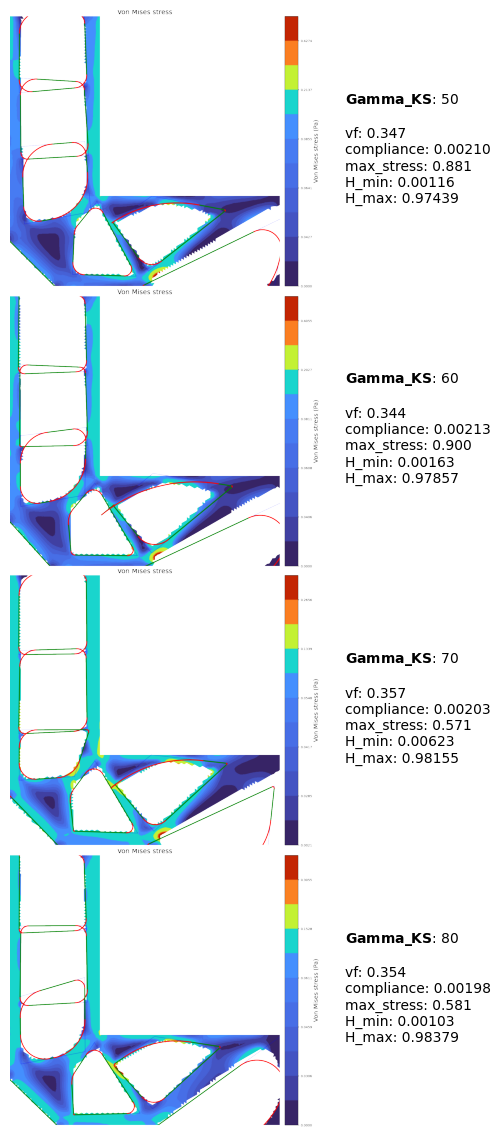

In [9]:
# config_name = "Brecket_fm_ae_hv"
# task_name = "LBrecket"

# config_name = "MBB_beam_half_fm_ae_hv" #
# task_name = "Beam"

# config_name = "Cant_beam_half_fm_ae_hv"
# task_name = "Cantilever Beam"

# config_name = "Cant_beam_distrL_fm_ae_hv"
# task_name = "Distributed Load Beam"

# config_name = "MBB_beam_half" #
# config_name = "Cant_beam"
# config_name = "Cant_beam_distrL"
config_name = "Brecket"

# task_name = "Beam"
# task_name = "Cantilever Beam"
# task_name = "Distributed Load Beam"
task_name = "LBrecket"

root_dir = "../src/gamma_ks_test"
task_dir = f"{root_dir}/{config_name}"

metrics = json.load(open(f"{task_dir}/metrics.json"))

plot_metrics(metrics, task_dir, task_name, num_experiments_per_plot=4, x_axis_scale=2.7)

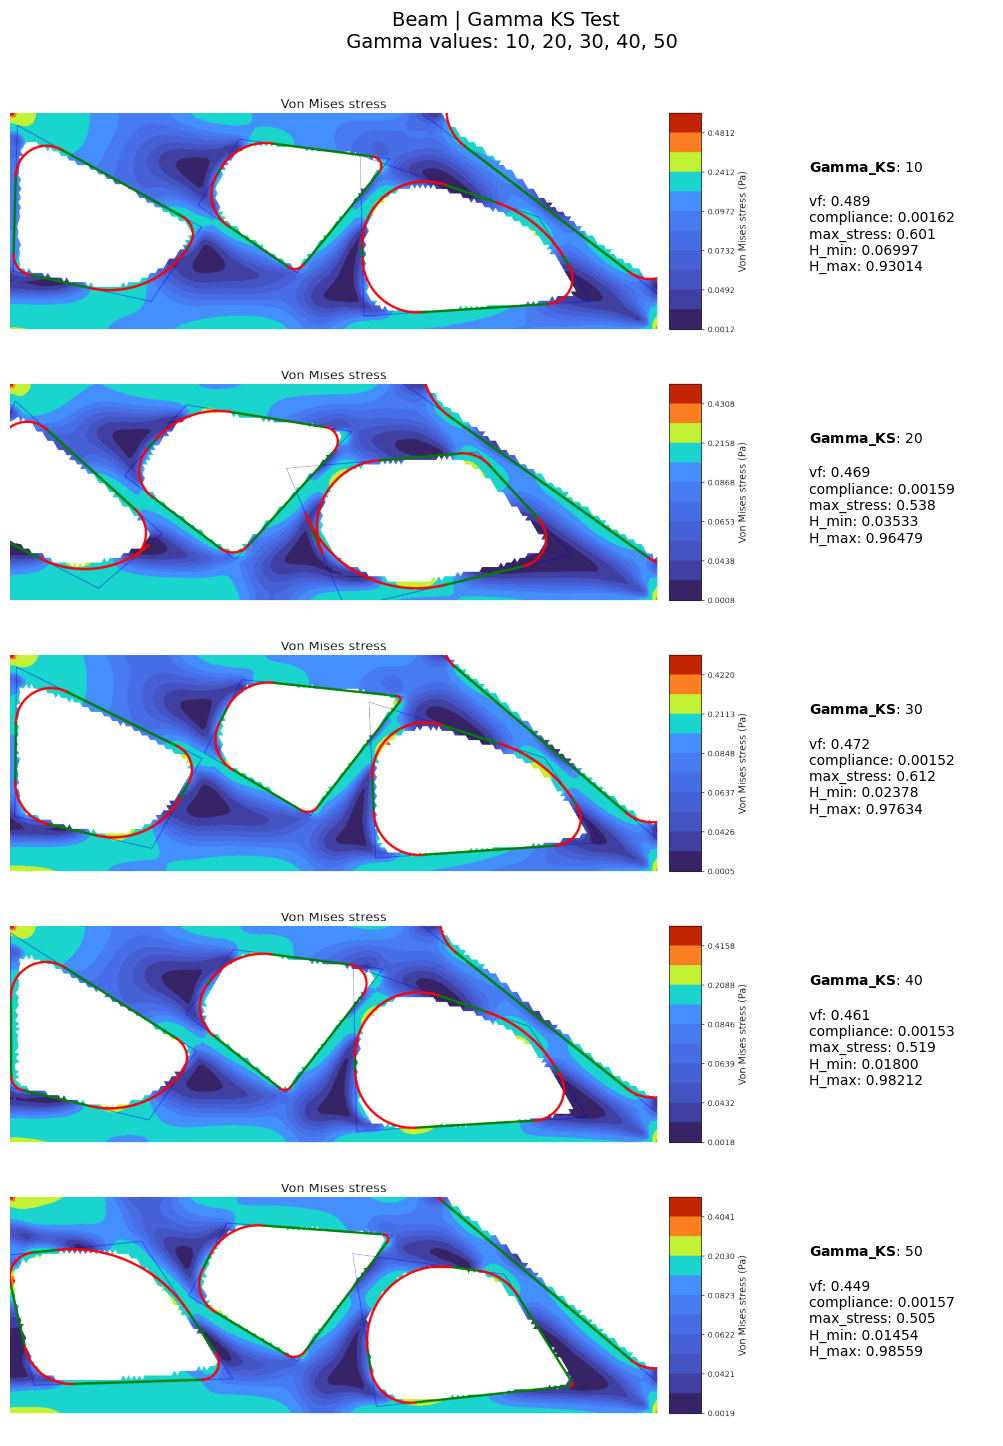

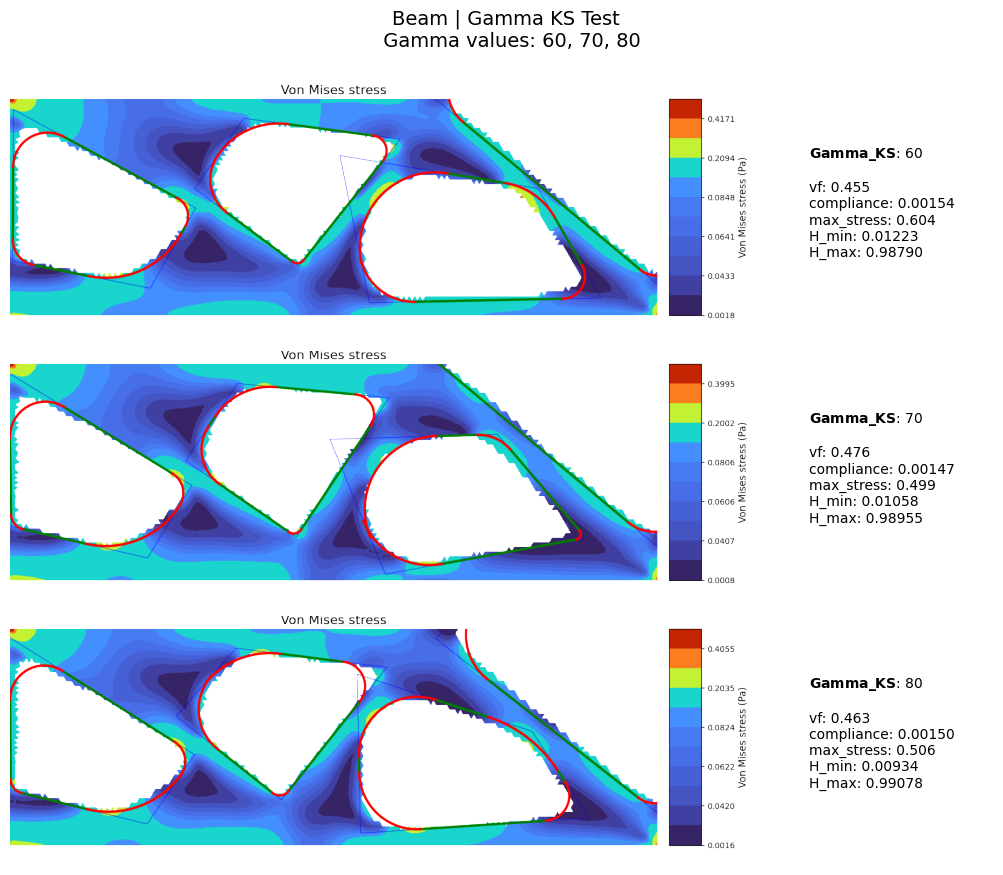

In [33]:
# config_name = "Brecket_fm_ae_hv"
# task_name = "LBrecket"

config_name = "MBB_beam_half_fm_ae_hv" #
task_name = "Beam"

# config_name = "Cant_beam_half_fm_ae_hv"
# task_name = "Cantilever Beam"

# config_name = "Cant_beam_distrL_fm_ae_hv"
# task_name = "Distributed Load Beam"

root_dir = "../src/gamma_ks_test"
task_dir = f"{root_dir}/{config_name}"

metrics = json.load(open(f"{task_dir}/metrics.json"))

plot_metrics(metrics, task_dir, task_name, num_experiments_per_plot=5, x_axis_scale=5, y_axis_scale=1.4)

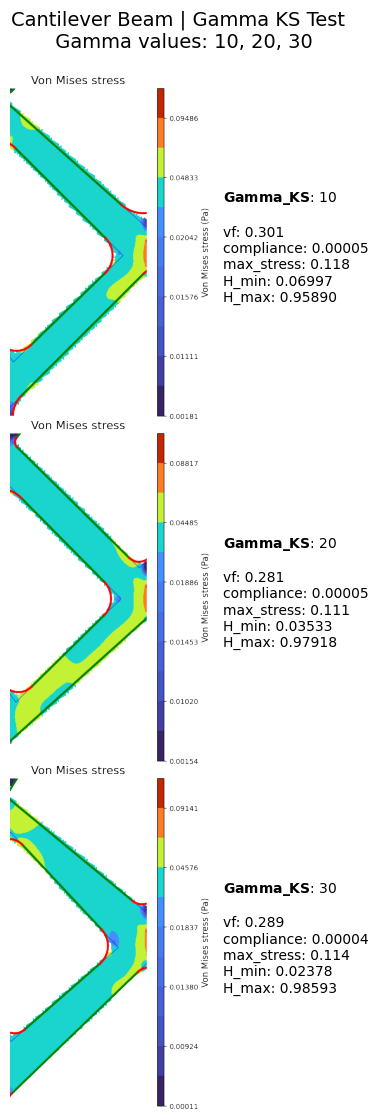

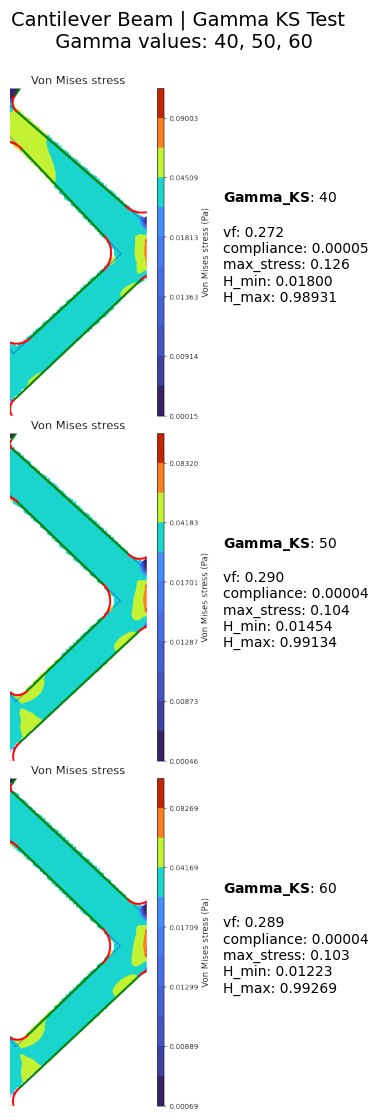

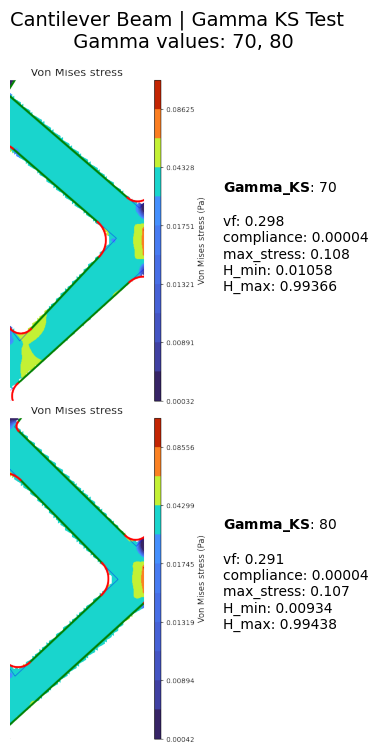

In [35]:
# config_name = "Brecket_fm_ae_hv"
# task_name = "LBrecket"

# config_name = "MBB_beam_half_fm_ae_hv" #
# task_name = "Beam"

config_name = "Cant_beam_half_fm_ae_hv"
task_name = "Cantilever Beam"

# config_name = "Cant_beam_distrL_fm_ae_hv"
# task_name = "Distributed Load Beam"

root_dir = "../src/gamma_ks_test"
task_dir = f"{root_dir}/{config_name}"

metrics = json.load(open(f"{task_dir}/metrics.json"))

plot_metrics(metrics, task_dir, task_name, num_experiments_per_plot=3, x_axis_scale=2, y_axis_scale=1.8)

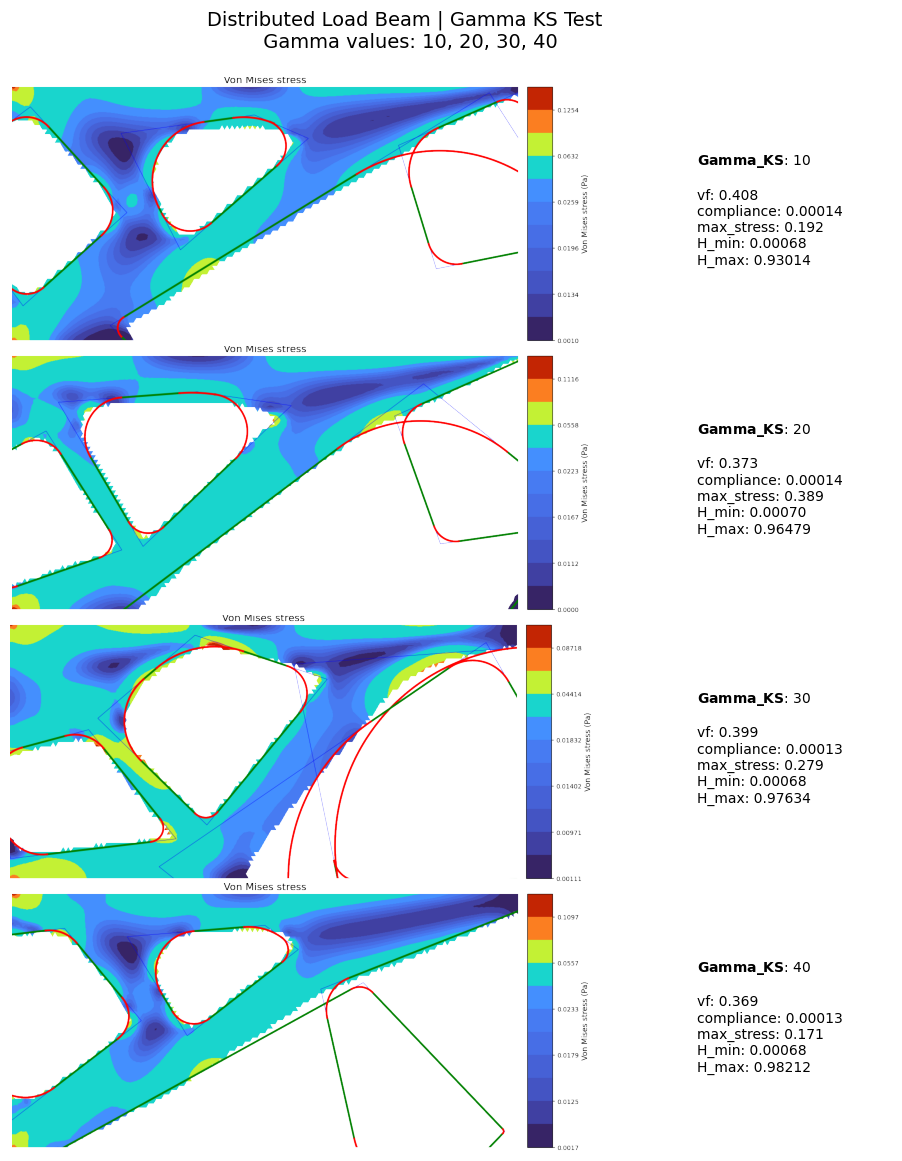

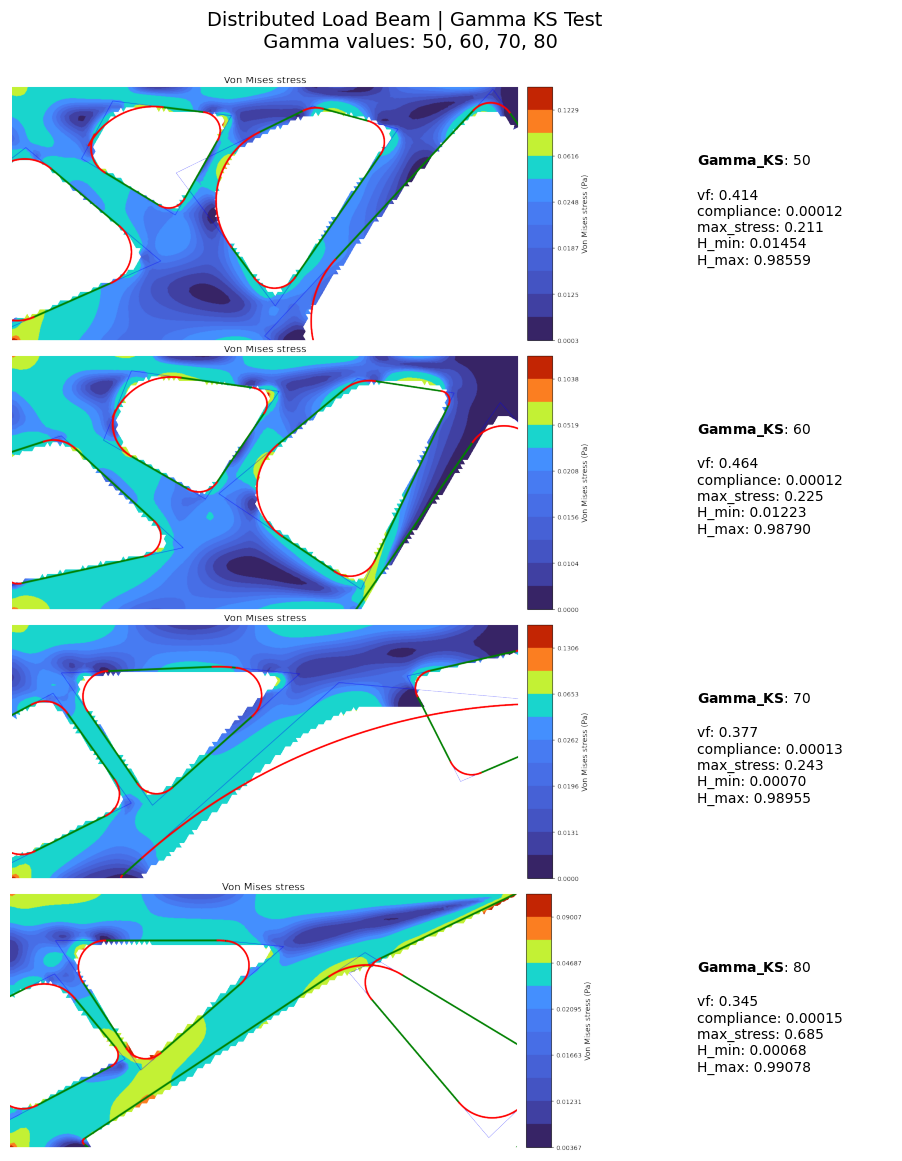

In [32]:
config_name = "Cant_beam_distrL_fm_ae_hv"
task_name = "Distributed Load Beam"

root_dir = "../src/gamma_ks_test"
task_dir = f"{root_dir}/{config_name}"

metrics = json.load(open(f"{task_dir}/metrics.json"))

plot_metrics(metrics, task_dir, task_name, num_experiments_per_plot=4, x_axis_scale=5, y_axis_scale=1.4)

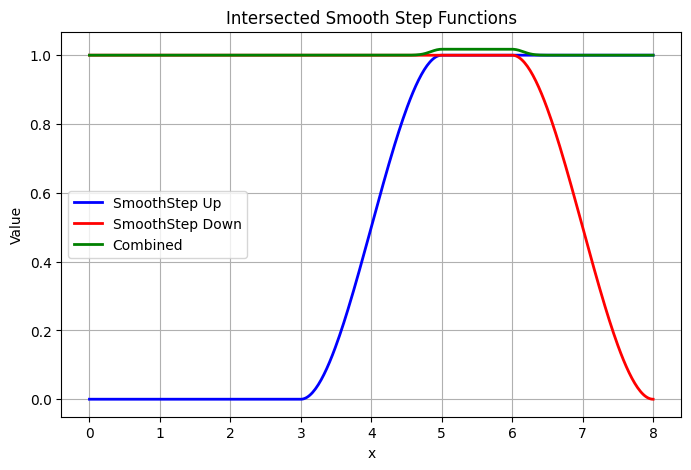

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def smoothstep(x, x0, width):
    """
    Smooth step function that transitions smoothly from 0 to 1.
    
    Parameters:
        x (array_like): Input array.
        x0 (float): Center of the transition.
        width (float): Total width of the transition region.
    
    Returns:
        array_like: Smoothed values between 0 and 1.
    """
    lower = x0 - width / 2
    upper = x0 + width / 2
    t = np.clip((x - lower) / (upper - lower), 0, 1)
    return t**2 * (3 - 2*t)

# Generate x values across the domain of interest
x = np.linspace(0, 8, 400)

# Define two smooth step functions:
# f1 increases from 0 to 1 centered at x=4 with a width of 2,
# while f2 is its complementary function, decreasing from 1 to 0.
f1 = smoothstep(x, 4, 2)
f2 = 1 - smoothstep(x-3, 4, 2)

sm_coeff = 40
f1_exp = np.exp(sm_coeff*f1)
f2_exp = np.exp(sm_coeff*f2)
f_combined = np.log(f1_exp + f2_exp)/sm_coeff



# kernel = torch.sigmoid(self.smooth_k*(kernel - 0.5))
# exp_kernel_sum = torch.exp(sm_coeff*kernel).sum(dim=1)+1e-8
# self.H = (1 - self.Emin)*(1 - torch.log(exp_kernel_sum)/sm_coeff) + self.Emin

# The functions intersect when they are equal.
# By symmetry they meet at the midpoint of the transition, which is x=4.
intersection_x = 4
intersection_y = smoothstep(intersection_x, 4, 2)

# Plot both functions and mark the intersection point
plt.figure(figsize=(8, 5))
plt.plot(x, f1, label="SmoothStep Up", color="blue", linewidth=2)
plt.plot(x, f2, label="SmoothStep Down", color="red", linewidth=2)
plt.plot(x, f_combined, label="Combined", color="green", linewidth=2)
# plt.plot(intersection_x, intersection_y, 'ko', markersize=8, 
#          label=f"Intersection ({intersection_x}, {intersection_y:.2f})")

plt.xlabel("x")
plt.ylabel("Value")
plt.title("Intersected Smooth Step Functions")
plt.legend()
plt.grid(True)
plt.show()


Max value of combined function:  1.0173286795139986
Min value of combined function:  0.01732867951399863


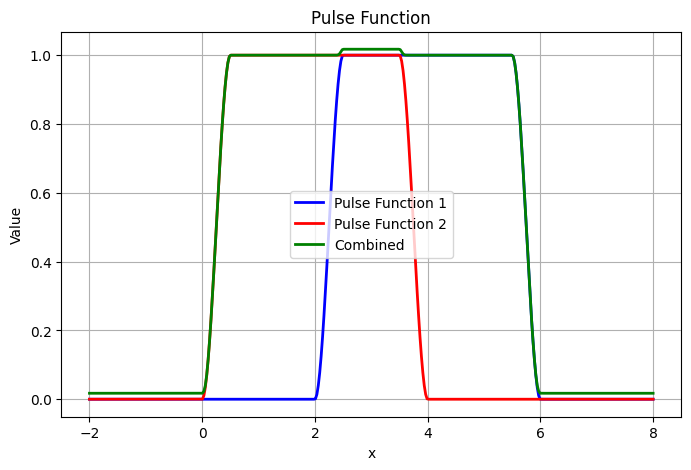

In [8]:
def pulse(x, center, width, transition):
    """
    Returns a smooth pulse function evaluated at x.

    The pulse is approximately 1 for values of x within the interval
    [center - width/2 + transition/2, center + width/2 - transition/2] and 
    smoothly transitions to 0 outside this range.

    Parameters:
        x : array_like
            Input value(s) where the pulse function is evaluated.
        center : float
            The center of the pulse.
        width : float
            The full width of the pulse region (including both transition regions).
        transition : float
            The width of each transition edge (should be less than width).

    Returns:
        array_like
            The evaluated pulse function with smooth transitions.
    """
    # Compute the rising edge: transitions from 0 to 1
    rise = smoothstep(x, center - width/2 + transition/2, transition)
    # Compute the falling edge: transitions from 1 to 0
    fall = smoothstep(x, center + width/2 - transition/2, transition)
    return rise - fall

center = 4
width = 4
transition = 0.5
x = np.linspace(-2, 8, 400)
pulse_function_1 = pulse(x, center, width, transition)
pulse_function_2 = pulse(x+2, center, width, transition)

sm_coeff = 40
f1_exp = np.exp(sm_coeff*pulse_function_1)
f2_exp = np.exp(sm_coeff*pulse_function_2)
f_combined = np.log(f1_exp + f2_exp)/sm_coeff

print("Max value of combined function: ", f_combined.max())
print("Min value of combined function: ", f_combined.min())

plt.figure(figsize=(8, 5))
plt.plot(x, pulse_function_1, label="Pulse Function 1", color="blue", linewidth=2)
plt.plot(x, pulse_function_2, label="Pulse Function 2", color="red", linewidth=2)
plt.plot(x, f_combined, label="Combined", color="green", linewidth=2)
plt.xlabel("x")
plt.ylabel("Value")
plt.title("Pulse Function")
plt.legend()
plt.grid(True)

exp_max:  2.718281828459045
exp_max:  7.38905609893065
exp_max:  20.085536923187668
exp_max:  54.598150033144236
exp_max:  148.4131591025766
exp_max:  403.4287934927351
exp_max:  1096.6331584284585
exp_max:  2980.9579870417283
exp_max:  8103.083927575384
exp_max:  22026.465794806718
exp_max:  59874.14171519782
exp_max:  162754.79141900392
exp_max:  442413.3920089205
exp_max:  1202604.2841647768
exp_max:  3269017.3724721107
exp_max:  8886110.520507872
exp_max:  24154952.7535753
exp_max:  65659969.13733051
exp_max:  178482300.96318725
exp_max:  485165195.4097903
exp_max:  1318815734.4832146
exp_max:  3584912846.131592
exp_max:  9744803446.248903
exp_max:  26489122129.84347
exp_max:  72004899337.38588
exp_max:  195729609428.83878
exp_max:  532048240601.79865
exp_max:  1446257064291.475
exp_max:  3931334297144.042
exp_max:  10686474581524.463
exp_max:  29048849665247.426
exp_max:  78962960182680.69
exp_max:  214643579785916.06
exp_max:  583461742527454.9
exp_max:  1586013452313430.8
exp_ma

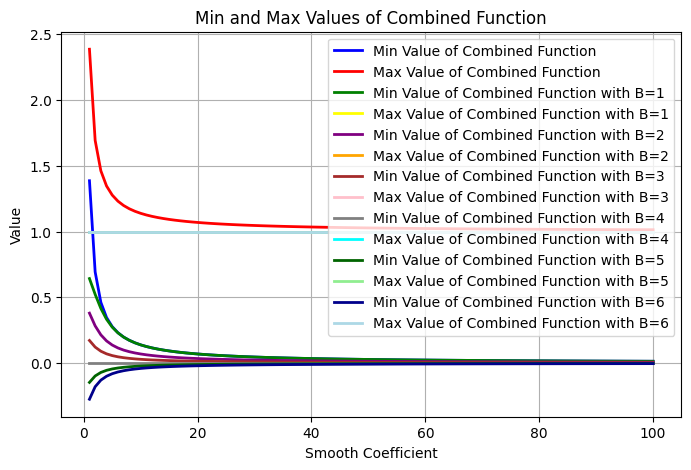

In [9]:
smooth_coeffs = np.linspace(1, 100, 100)
min_values = []
max_values = []
single_f_min = []
single_f_max = []
double_f_min = []
double_f_max = []
double_f_min_2 = []
double_f_max_2 = []
double_f_min_3 = []
double_f_max_3 = []
double_f_min_4 = []
double_f_max_4 = []
double_f_min_5 = []
double_f_max_5 = []
double_f_min_6 = []
double_f_max_6 = []
double_f_min_7 = []
double_f_max_7 = []

B = 4
for smooth_coeff in smooth_coeffs:
    f1_exp = np.exp(smooth_coeff*pulse_function_1)
    f2_exp = np.exp(smooth_coeff*pulse_function_2)
    f_combined_single = np.log(f1_exp + (B-1))/smooth_coeff
    f_combined_double = np.log(2*f1_exp + (B-2))/smooth_coeff
    f_combined_double_2 = np.log(3*f1_exp + (B-3))/smooth_coeff
    f_combined_double_3 = np.log(4*f1_exp + (B-4))/smooth_coeff
    f_combined_double_4 = np.log(5*f1_exp + (B-5))/smooth_coeff
    f_combined_double_5 = np.log(6*f1_exp + (B-6))/smooth_coeff
    f_combined_double_6 = np.log(7*f1_exp + (B-7))/smooth_coeff
    f_combined_double_7 = np.log(8*f1_exp + (B-8))/smooth_coeff
    
    f_combined = np.log(f1_exp*B)/smooth_coeff
    fc_min_formula = np.log(B)/smooth_coeff
    fc_max_formula = np.log(B*np.exp(smooth_coeff))/smooth_coeff

    print("exp_max: ", np.exp(smooth_coeff))

    adjusted_combined_f = (fc_max_formula - f_combined_single)/(fc_max_formula - fc_min_formula)
    adjusted_combined_f_double = (fc_max_formula - f_combined_double)/(fc_max_formula - fc_min_formula)
    adjusted_combined_f_double_2 = (fc_max_formula - f_combined_double_2)/(fc_max_formula - fc_min_formula)
    adjusted_combined_f_double_3 = (fc_max_formula - f_combined_double_3)/(fc_max_formula - fc_min_formula)
    adjusted_combined_f_double_4 = (fc_max_formula - f_combined_double_4)/(fc_max_formula - fc_min_formula)
    adjusted_combined_f_double_5 = (fc_max_formula - f_combined_double_5)/(fc_max_formula - fc_min_formula)
    adjusted_combined_f_double_6 = (fc_max_formula - f_combined_double_6)/(fc_max_formula - fc_min_formula)
    adjusted_combined_f_double_7 = (fc_max_formula - f_combined_double_7)/(fc_max_formula - fc_min_formula)

    # print(f"Min value of combined function {smooth_coeff}: {f_combined.min()}, Min value of formula: {fc_min_formula}")
    # print(f"Max value of combined function {smooth_coeff}: {f_combined.max()}, Max value of formula: {fc_max_formula}")
    # print(f"Adjusted max value of combined function {smooth_coeff}: {adjusted_combined_f.max()}")
    # print(f"Adjusted min value of combined function {smooth_coeff}: {adjusted_combined_f.min()}")
    min_values.append(f_combined.min())
    max_values.append(f_combined.max())
    single_f_min.append(adjusted_combined_f.min())
    single_f_max.append(adjusted_combined_f.max())
    double_f_min.append(adjusted_combined_f_double.min())
    double_f_max.append(adjusted_combined_f_double.max())
    double_f_min_2.append(adjusted_combined_f_double_2.min())
    double_f_max_2.append(adjusted_combined_f_double_2.max())
    double_f_min_3.append(adjusted_combined_f_double_3.min())
    double_f_max_3.append(adjusted_combined_f_double_3.max())
    double_f_min_4.append(adjusted_combined_f_double_4.min())
    double_f_max_4.append(adjusted_combined_f_double_4.max())
    double_f_min_5.append(adjusted_combined_f_double_5.min())
    double_f_max_5.append(adjusted_combined_f_double_5.max())
    double_f_min_6.append(adjusted_combined_f_double_6.min())
    double_f_max_6.append(adjusted_combined_f_double_6.max())
    double_f_min_7.append(adjusted_combined_f_double_7.min())
    double_f_max_7.append(adjusted_combined_f_double_7.max())
    
plt.figure(figsize=(8, 5))
plt.plot(smooth_coeffs, min_values, label="Min Value of Combined Function", color="blue", linewidth=2)
plt.plot(smooth_coeffs, max_values, label="Max Value of Combined Function", color="red", linewidth=2)
plt.plot(smooth_coeffs, single_f_min, label="Min Value of Combined Function with B=1", color="green", linewidth=2)
plt.plot(smooth_coeffs, single_f_max, label="Max Value of Combined Function with B=1", color="yellow", linewidth=2)
plt.plot(smooth_coeffs, double_f_min, label="Min Value of Combined Function with B=2", color="purple", linewidth=2)
plt.plot(smooth_coeffs, double_f_max, label="Max Value of Combined Function with B=2", color="orange", linewidth=2)
plt.plot(smooth_coeffs, double_f_min_2, label="Min Value of Combined Function with B=3", color="brown", linewidth=2)
plt.plot(smooth_coeffs, double_f_max_2, label="Max Value of Combined Function with B=3", color="pink", linewidth=2)
plt.plot(smooth_coeffs, double_f_min_3, label="Min Value of Combined Function with B=4", color="gray", linewidth=2)
plt.plot(smooth_coeffs, double_f_max_3, label="Max Value of Combined Function with B=4", color="cyan", linewidth=2)
plt.plot(smooth_coeffs, double_f_min_4, label="Min Value of Combined Function with B=5", color="darkgreen", linewidth=2)
plt.plot(smooth_coeffs, double_f_max_4, label="Max Value of Combined Function with B=5", color="lightgreen", linewidth=2)
plt.plot(smooth_coeffs, double_f_min_5, label="Min Value of Combined Function with B=6", color="darkblue", linewidth=2)
plt.plot(smooth_coeffs, double_f_max_5, label="Max Value of Combined Function with B=6", color="lightblue", linewidth=2)





plt.xlabel("Smooth Coefficient")
plt.ylabel("Value")
plt.title("Min and Max Values of Combined Function")
plt.legend()
plt.grid(True)

In [13]:
print(single_f_min)
print(single_f_max)

[0.5471675747360588, 0.42953376122311254, 0.33456311074904965, 0.2656589972299792, 0.21704527738933227, 0.1822778387127688, 0.1566843122535977, 0.1372426985477542, 0.12204061105720942, 0.10985214929306421, 0.09987080780221902, 0.09155000002657543, 0.08450828984765481, 0.078472187543718, 0.07324077845757704, 0.06866325397486173, 0.0646242474040799, 0.0610340143448973, 0.05782169881381671, 0.05493061422729027, 0.05231487081674269, 0.04993692218682799, 0.047765751672298906, 0.04577551202469209, 0.04394449154561331, 0.04225431879453434, 0.04068934402460567, 0.03923615316666895, 0.03788318236784827, 0.036620409622264205, 0.035439106086065715, 0.03433163402087747, 0.03329128147479099, 0.03231212613729718, 0.03138892253337455, 0.03051700801855861, 0.029692224018057045, 0.028910849701792255, 0.028169545863284906, 0.027465307216702598, 0.026795421674831846, 0.026157435444478686, 0.025549122992281518, 0.02496846110609341, 0.024413606414846804, 0.023882875840611106, 0.023374729546129958, 0.022887

In [ ]:


sm_coeff = 40
f1_exp = np.exp(sm_coeff*f1)
f2_exp = np.exp(sm_coeff*f2)
f_combined = np.log(f1_exp + f2_exp)/sm_coeff

In [4]:
# config_name = "MBB_beam_half_fm_ae_hv" #
config_name = "Cant_beam_half_fm_ae_hv"
task_name = "Cantilever Beam"

# gamma_ks_list = [20, 30, 40, 60, 80]
# gamma_ks_list = [2, 5, 7, 10]



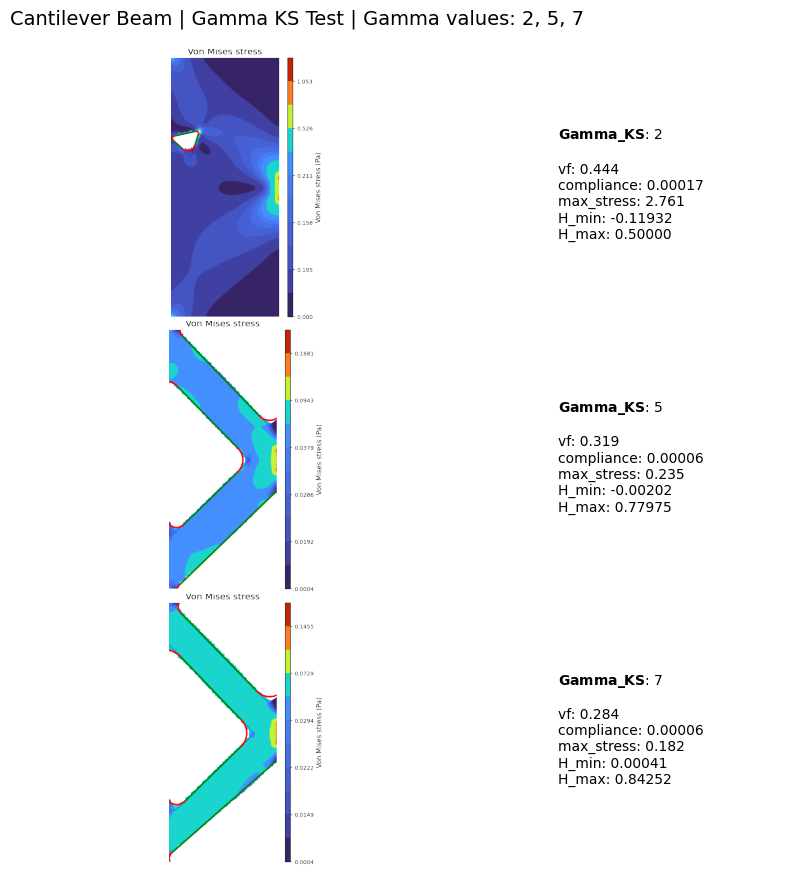

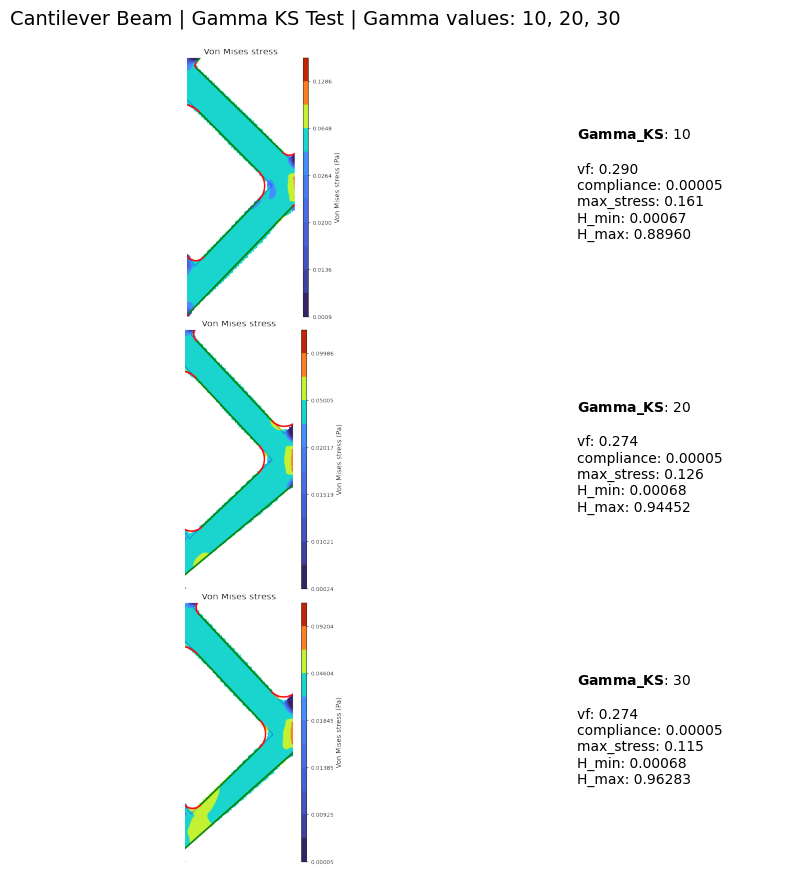

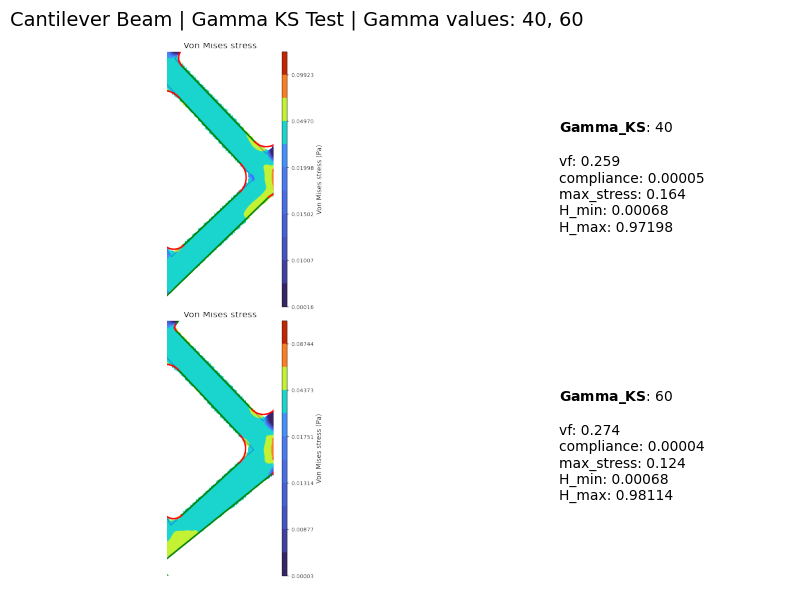

In [7]:
metrics = json.load(open(f"{task_dir}/metrics.json"))

plot_metrics(metrics, task_dir, task_name, gamma_ks_list, num_experiments_per_plot=3)

Info    : Reading '../test_problems/Cantilever_beam_distributed_load.msh'...
Info    : 9 entities
Info    : 5964 nodes
Info    : 11626 elements
Info    : Done reading '../test_problems/Cantilever_beam_distributed_load.msh'
Compute areas ...


100%|██████████| 11626/11626 [00:00<00:00, 175559.85it/s]


Whole area 0.5


100%|██████████| 11626/11626 [00:00<00:00, 33554.36it/s]
/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/NN_TopOpt/NN_TopOpt.py:1124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

Fixed case:  fixed_xy [0, [0, 0.5]] 51 5964
Loaded loads:  (101,)
60


/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/NN_TopOpt/NN_TopOpt.py:1652: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  self.H.T @ self.volumes/volume_goal - 1


Iteration: 1 | current volfrac: 0.911010 | compliance: 0.000049
Iteration: 2 | current volfrac: 0.907929 | compliance: 0.000049
Iteration: 3 | current volfrac: 0.904497 | compliance: 0.000049
Iteration: 4 | current volfrac: 0.900690 | compliance: 0.000049
Iteration: 5 | current volfrac: 0.896583 | compliance: 0.000049
Iteration: 6 | current volfrac: 0.892212 | compliance: 0.000049
Iteration: 7 | current volfrac: 0.887382 | compliance: 0.000049
Iteration: 8 | current volfrac: 0.882366 | compliance: 0.000049
Iteration: 9 | current volfrac: 0.876870 | compliance: 0.000050
Iteration: 10 | current volfrac: 0.870775 | compliance: 0.000050
Iteration: 11 | current volfrac: 0.864211 | compliance: 0.000050
Iteration: 12 | current volfrac: 0.857167 | compliance: 0.000051
Iteration: 13 | current volfrac: 0.849392 | compliance: 0.000051
Iteration: 14 | current volfrac: 0.841066 | compliance: 0.000051
Iteration: 15 | current volfrac: 0.831997 | compliance: 0.000052
Iteration: 16 | current volfrac: 0

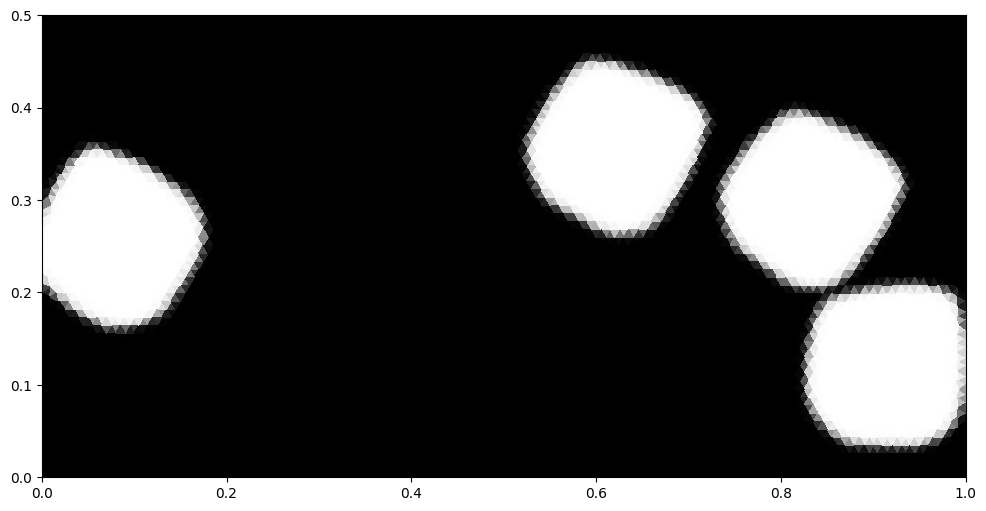

Iteration: 20 | current volfrac: 0.770948 | compliance: 0.000057
Iteration: 21 | current volfrac: 0.755239 | compliance: 0.000058
Iteration: 22 | current volfrac: 0.737972 | compliance: 0.000060
Iteration: 23 | current volfrac: 0.719590 | compliance: 0.000062
Iteration: 24 | current volfrac: 0.700446 | compliance: 0.000065
Iteration: 25 | current volfrac: 0.679304 | compliance: 0.000069
Iteration: 26 | current volfrac: 0.656320 | compliance: 0.000075
Iteration: 27 | current volfrac: 0.634728 | compliance: 0.000082
Iteration: 28 | current volfrac: 0.617450 | compliance: 0.000085
Iteration: 29 | current volfrac: 0.601632 | compliance: 0.000090
Iteration: 30 | current volfrac: 0.585244 | compliance: 0.000097
Iteration: 31 | current volfrac: 0.569195 | compliance: 0.000103
Iteration: 32 | current volfrac: 0.554815 | compliance: 0.000108
Iteration: 33 | current volfrac: 0.543956 | compliance: 0.000113
Iteration: 34 | current volfrac: 0.539037 | compliance: 0.000113
Iteration: 35 | current v

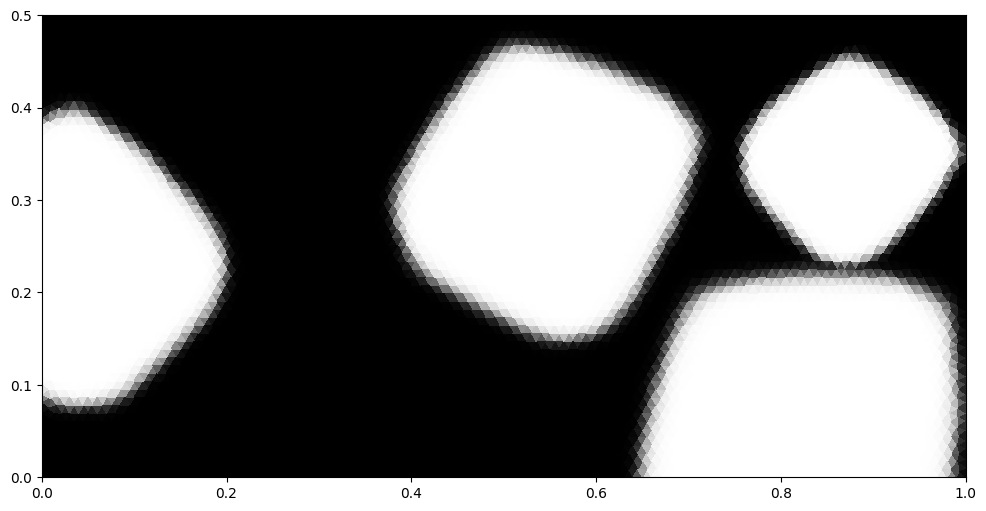

Iteration: 40 | current volfrac: 0.539503 | compliance: 0.000098
Global iteration 40 is within one of the shape optimization ranges.
Iteration: 41 | current volfrac: 0.531350 | compliance: 0.000096
Global iteration 41 is within one of the shape optimization ranges.
Iteration: 42 | current volfrac: 0.522405 | compliance: 0.000096
Global iteration 42 is within one of the shape optimization ranges.
Iteration: 43 | current volfrac: 0.514690 | compliance: 0.000095
Global iteration 43 is within one of the shape optimization ranges.
Refactoring started ...
Iteration: 44 | current volfrac: 0.511377 | compliance: 0.000094
Global iteration 44 is within one of the shape optimization ranges.
Iteration: 45 | current volfrac: 0.490531 | compliance: 0.000097
Global iteration 45 is within one of the shape optimization ranges.
Iteration: 46 | current volfrac: 0.465214 | compliance: 0.000106
Global iteration 46 is within one of the shape optimization ranges.
Iteration: 47 | current volfrac: 0.450041 | c

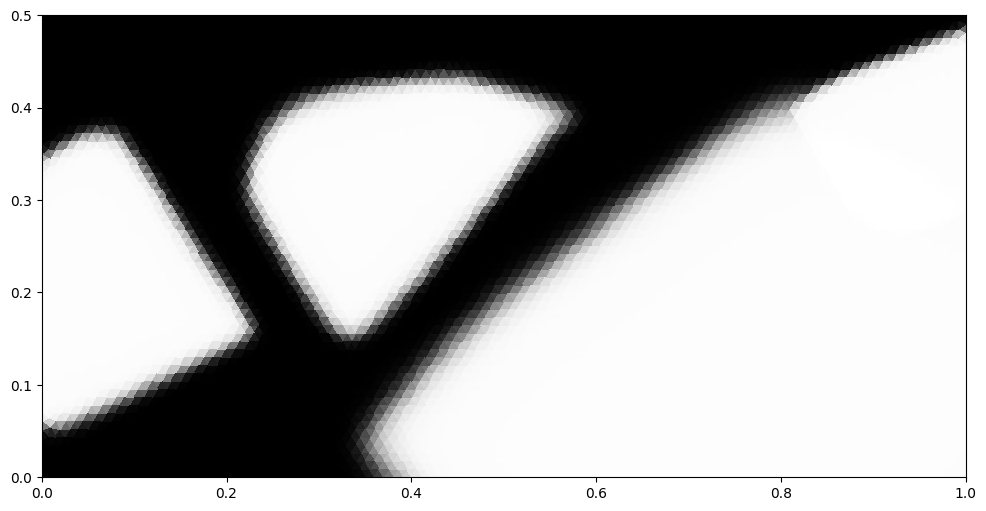

Iteration: 60 | current volfrac: 0.384663 | compliance: 0.000128
Global iteration 60 is within one of the shape optimization ranges.
Iteration: 61 | current volfrac: 0.373601 | compliance: 0.000133
Global iteration 61 is within one of the shape optimization ranges.
Iteration: 62 | current volfrac: 0.361527 | compliance: 0.000140
Global iteration 62 is within one of the shape optimization ranges.
Iteration: 63 | current volfrac: 0.354441 | compliance: 0.000143
Global iteration 63 is within one of the shape optimization ranges.
Refactoring started ...
Iteration: 64 | current volfrac: 0.369069 | compliance: 0.000133
Global iteration 64 is within one of the shape optimization ranges.
Iteration: 65 | current volfrac: 0.360806 | compliance: 0.000138
Global iteration 65 is within one of the shape optimization ranges.
Iteration: 66 | current volfrac: 0.352702 | compliance: 0.000140
Global iteration 66 is within one of the shape optimization ranges.
Iteration: 67 | current volfrac: 0.345306 | c

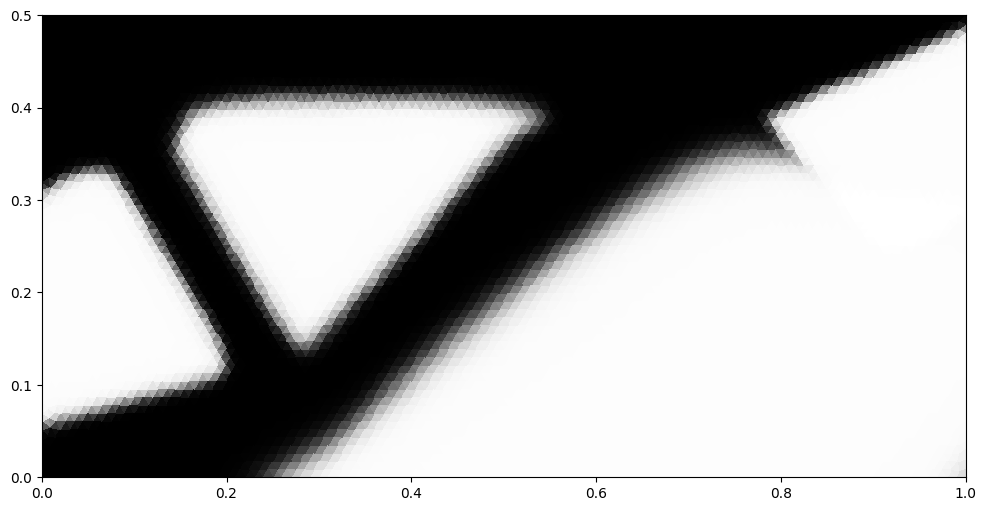

Computing stresses: 100%|██████████| 11626/11626 [00:00<00:00, 91826.30it/s]


0.13689157639353328 6.681927205966777e-05


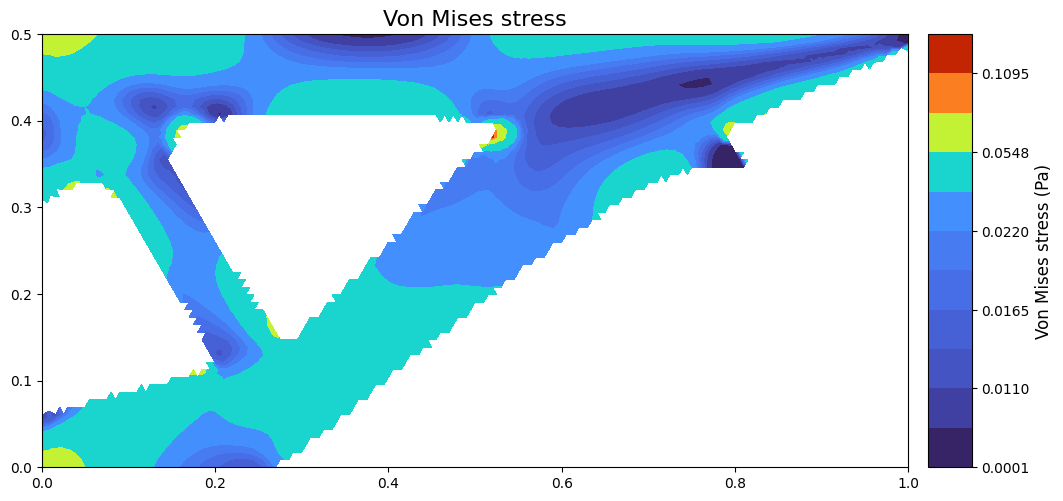

vf: 0.398767 | compliance: 0.000115 | max_stress: 0.247261
0.13689157639353328 6.681927205966777e-05


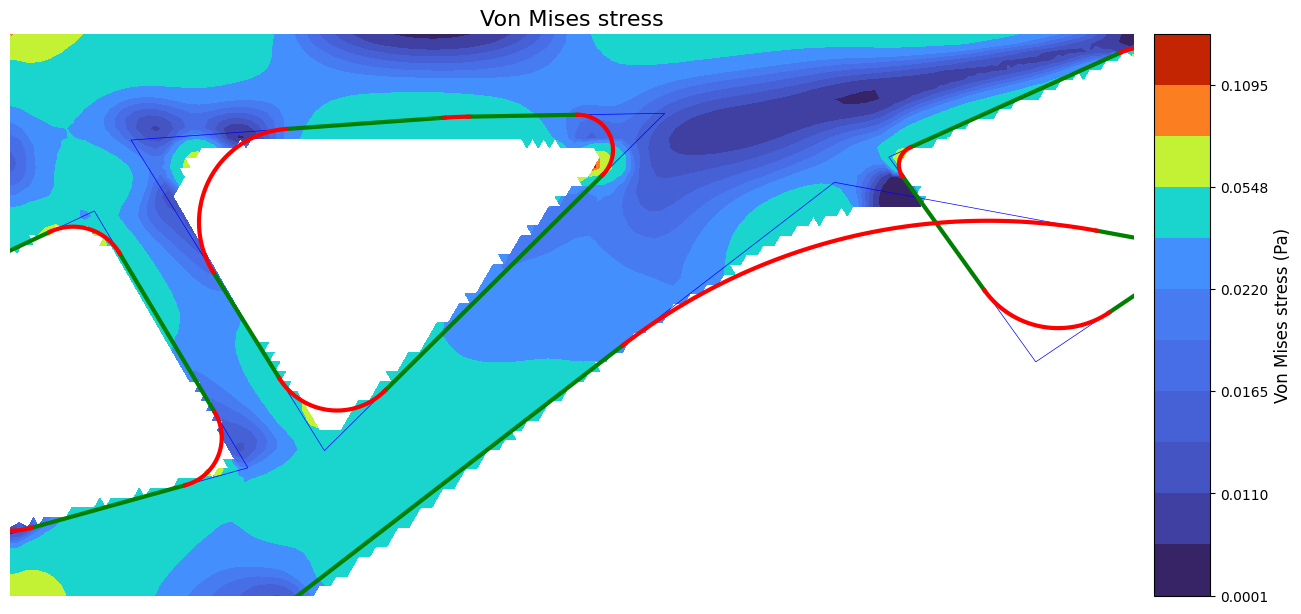

Info    : Reading '../test_problems/Cantilever_beam_distributed_load.msh'...
Info    : 9 entities
Info    : 5964 nodes
Info    : 11626 elements
Info    : Done reading '../test_problems/Cantilever_beam_distributed_load.msh'
Compute areas ...


100%|██████████| 11626/11626 [00:00<00:00, 172661.82it/s]


Whole area 0.5


100%|██████████| 11626/11626 [00:00<00:00, 29774.77it/s]


Fixed case:  fixed_xy [0, [0, 0.5]] 51 5964
Loaded loads:  (101,)
80
Iteration: 1 | current volfrac: 0.916323 | compliance: 0.000048
Iteration: 2 | current volfrac: 0.913190 | compliance: 0.000048
Iteration: 3 | current volfrac: 0.909655 | compliance: 0.000048
Iteration: 4 | current volfrac: 0.905970 | compliance: 0.000048
Iteration: 5 | current volfrac: 0.901821 | compliance: 0.000048
Iteration: 6 | current volfrac: 0.897340 | compliance: 0.000048
Iteration: 7 | current volfrac: 0.892465 | compliance: 0.000048
Iteration: 8 | current volfrac: 0.887521 | compliance: 0.000049
Iteration: 9 | current volfrac: 0.881776 | compliance: 0.000049
Iteration: 10 | current volfrac: 0.875644 | compliance: 0.000049
Iteration: 11 | current volfrac: 0.868933 | compliance: 0.000049
Iteration: 12 | current volfrac: 0.861670 | compliance: 0.000050
Iteration: 13 | current volfrac: 0.853890 | compliance: 0.000050
Iteration: 14 | current volfrac: 0.845336 | compliance: 0.000050
Iteration: 15 | current volfra

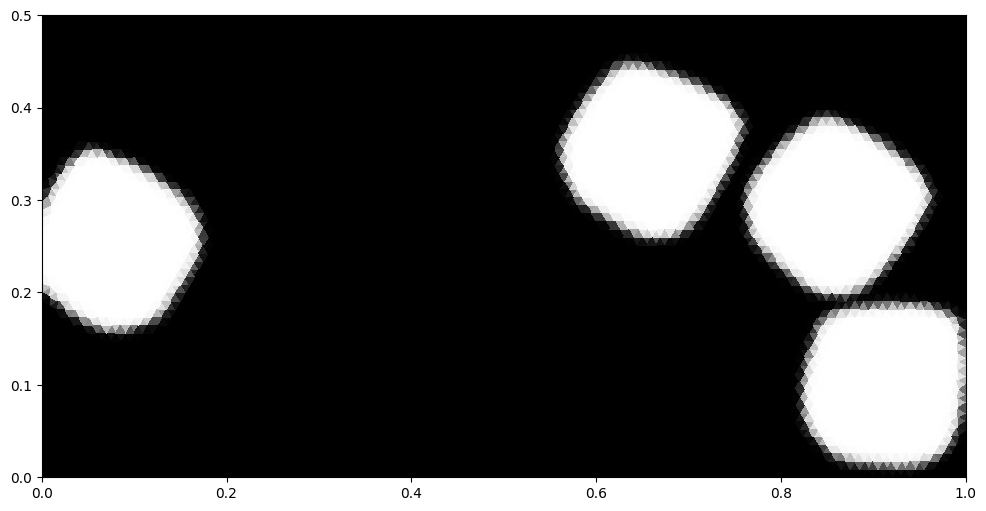

Iteration: 20 | current volfrac: 0.775294 | compliance: 0.000055
Iteration: 21 | current volfrac: 0.759511 | compliance: 0.000056
Iteration: 22 | current volfrac: 0.743074 | compliance: 0.000058
Iteration: 23 | current volfrac: 0.725115 | compliance: 0.000060
Iteration: 24 | current volfrac: 0.705778 | compliance: 0.000062
Iteration: 25 | current volfrac: 0.687012 | compliance: 0.000064
Iteration: 26 | current volfrac: 0.667680 | compliance: 0.000066
Iteration: 27 | current volfrac: 0.646393 | compliance: 0.000070
Iteration: 28 | current volfrac: 0.622805 | compliance: 0.000074
Iteration: 29 | current volfrac: 0.597457 | compliance: 0.000080
Iteration: 30 | current volfrac: 0.571540 | compliance: 0.000086
Iteration: 31 | current volfrac: 0.545707 | compliance: 0.000094
Iteration: 32 | current volfrac: 0.521826 | compliance: 0.000103
Iteration: 33 | current volfrac: 0.518061 | compliance: 0.000101
Iteration: 34 | current volfrac: 0.513175 | compliance: 0.000100
Iteration: 35 | current v

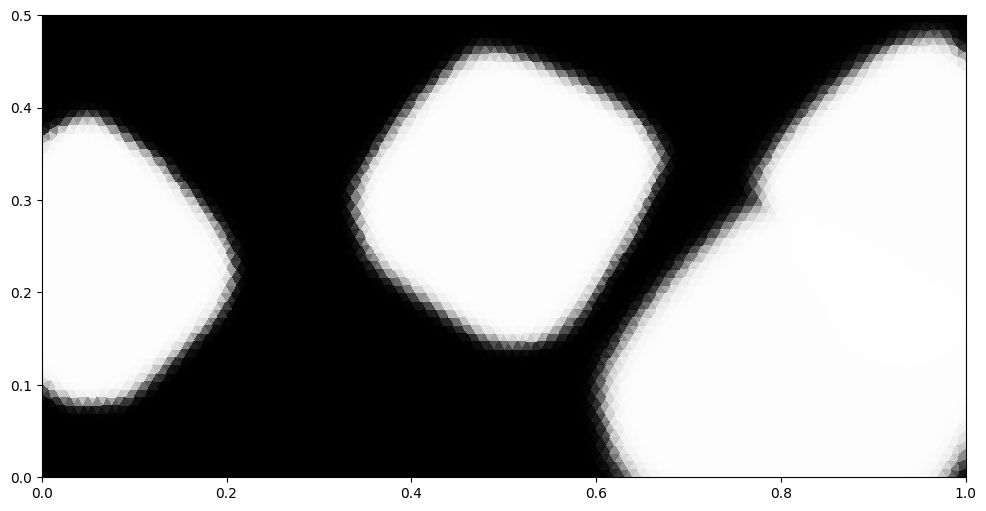

Iteration: 40 | current volfrac: 0.485576 | compliance: 0.000100
Global iteration 40 is within one of the shape optimization ranges.
Iteration: 41 | current volfrac: 0.479426 | compliance: 0.000098
Global iteration 41 is within one of the shape optimization ranges.
Iteration: 42 | current volfrac: 0.468503 | compliance: 0.000103
Global iteration 42 is within one of the shape optimization ranges.
Iteration: 43 | current volfrac: 0.466701 | compliance: 0.000098
Global iteration 43 is within one of the shape optimization ranges.
Refactoring started ...
Iteration: 44 | current volfrac: 0.463885 | compliance: 0.000097
Global iteration 44 is within one of the shape optimization ranges.
Iteration: 45 | current volfrac: 0.452895 | compliance: 0.000101
Global iteration 45 is within one of the shape optimization ranges.
Iteration: 46 | current volfrac: 0.439657 | compliance: 0.000105
Global iteration 46 is within one of the shape optimization ranges.
Iteration: 47 | current volfrac: 0.424453 | c

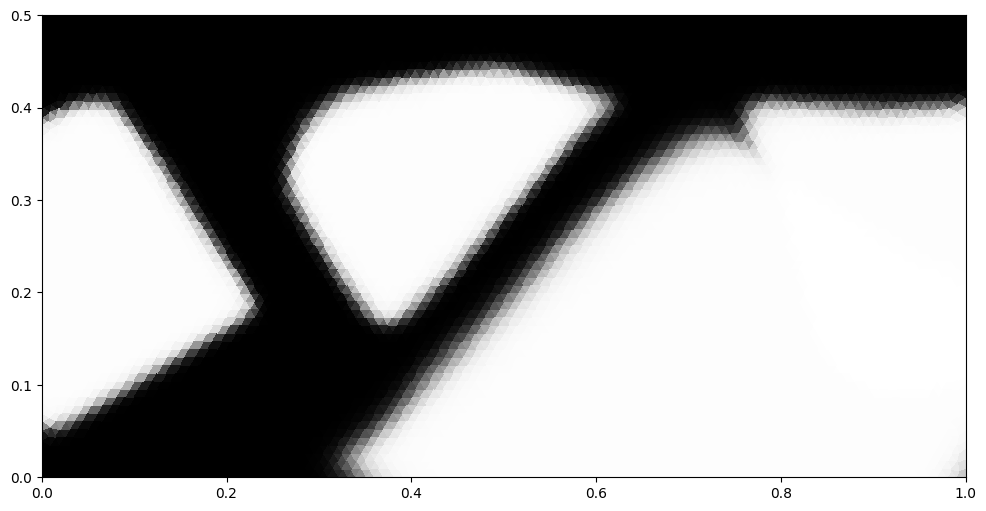

Iteration: 60 | current volfrac: 0.392714 | compliance: 0.000129
Global iteration 60 is within one of the shape optimization ranges.
Iteration: 61 | current volfrac: 0.396138 | compliance: 0.000127
Global iteration 61 is within one of the shape optimization ranges.
Iteration: 62 | current volfrac: 0.394738 | compliance: 0.000128
Global iteration 62 is within one of the shape optimization ranges.
Iteration: 63 | current volfrac: 0.388300 | compliance: 0.000132
Global iteration 63 is within one of the shape optimization ranges.
Refactoring started ...
Iteration: 64 | current volfrac: 0.378007 | compliance: 0.000140
Global iteration 64 is within one of the shape optimization ranges.
Iteration: 65 | current volfrac: 0.373828 | compliance: 0.000142
Global iteration 65 is within one of the shape optimization ranges.
Iteration: 66 | current volfrac: 0.376297 | compliance: 0.000139
Global iteration 66 is within one of the shape optimization ranges.
Iteration: 67 | current volfrac: 0.381385 | c

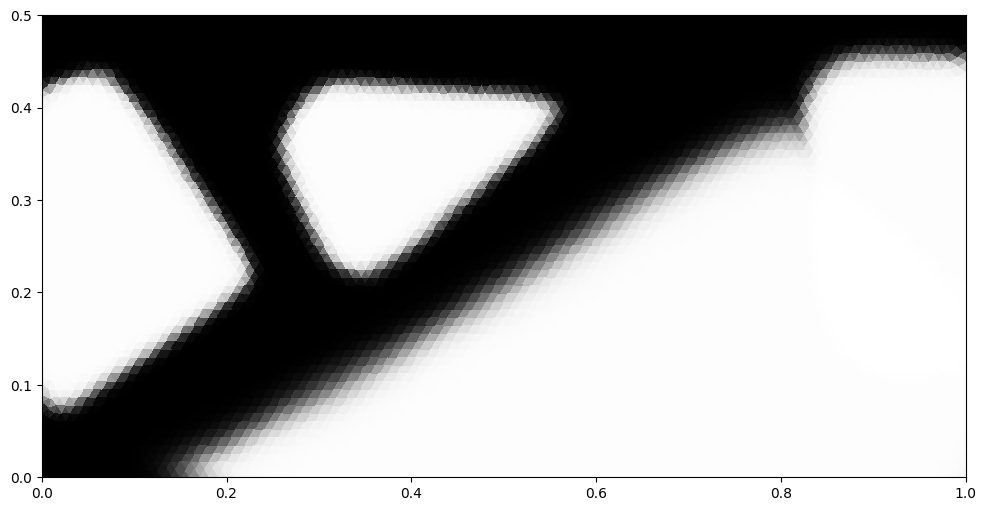

Computing stresses: 100%|██████████| 11626/11626 [00:00<00:00, 99873.79it/s]


0.1570686181590495 0.00045683055517712934


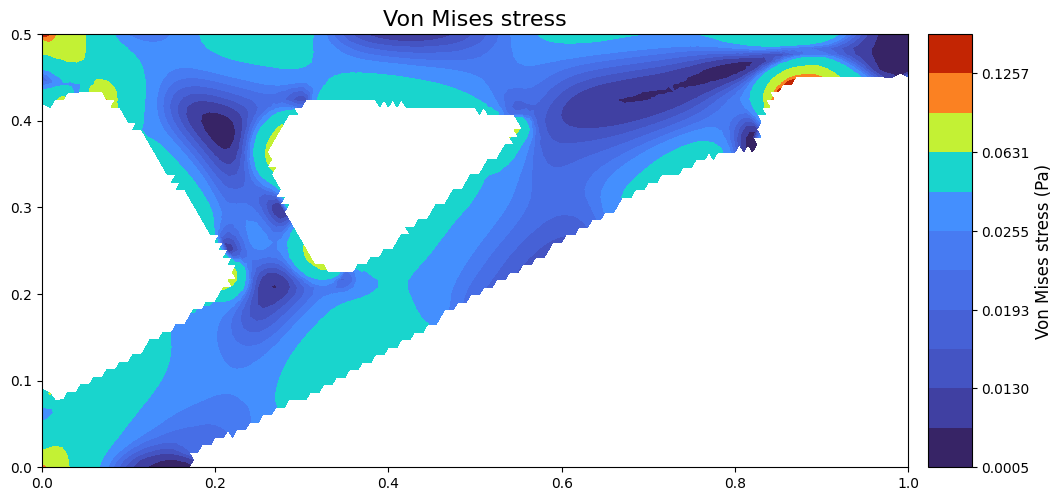

vf: 0.380379 | compliance: 0.000128 | max_stress: 0.572492
0.1570686181590495 0.00045683055517712934


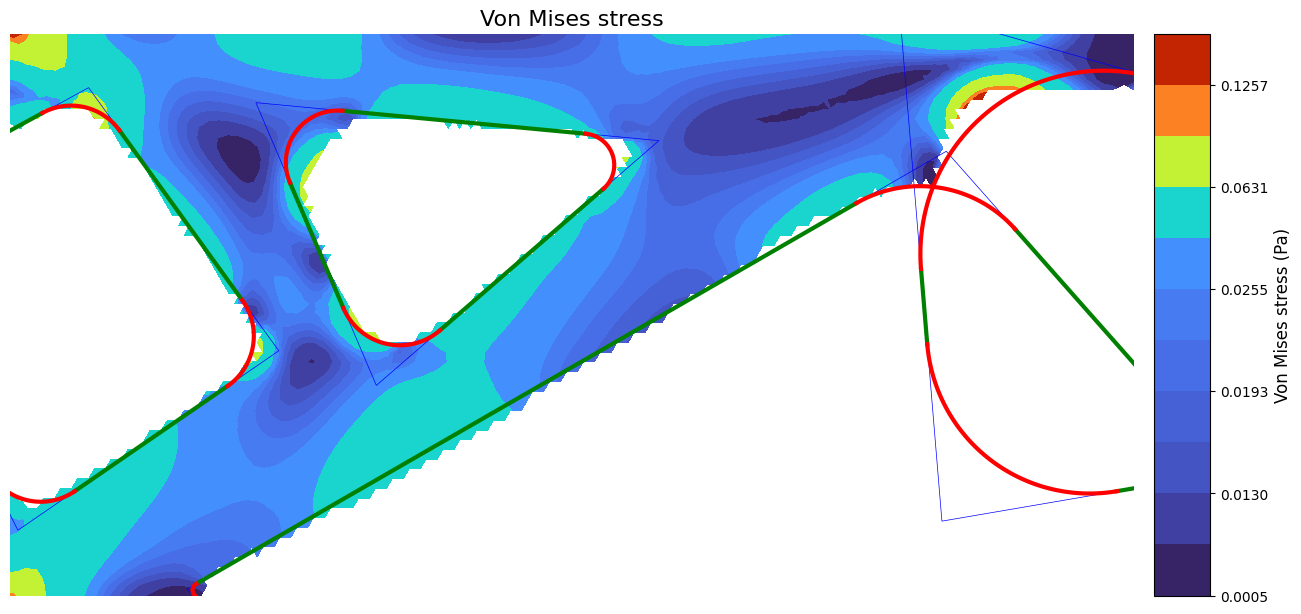

In [5]:
# config_name = "MBB_beam_half_fm_ae_hv" #
# config_name = "Cant_beam_half_fm_ae_hv"
config_name = "Cant_beam_distrL_fm_ae_hv"
# config_name = "Brecket_fm_ae_hv"

task_name = "Distributed_Load_Beam"

# gamma_ks_list = [20, 30, 40, 60, 80]
# gamma_ks_list = [2, 5, 7, 10, 20, 30, 40, 60, 80]
gamma_ks_list = [60, 80]

config_path = f"{experiment_dir}/{config_name}.yaml"

with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

params = config['params']
params['refactoring_markers'] = list(range(38, 80, 5))

metrics = {
    # "gamma_ks": [],
    "vf": [],
    "compliance": [],
    "max_stress": [],
    "H_min": [],
    "H_max": [],
    "filename": [],
}

root_dir = "../src/gamma_ks_test"
os.makedirs(root_dir, exist_ok=True)

task_dir = f"{root_dir}/{config_name}"
os.makedirs(task_dir, exist_ok=True)

for gamma_ks in gamma_ks_list:
    vf, compliance, max_stress, filename, H_min, H_max = gamma_ks_experiment(gamma_ks, methods, params, task_dir)

    # metrics["gamma_ks"].append(gamma_ks)
    metrics["vf"].append(vf)
    metrics["compliance"].append(compliance)
    metrics["max_stress"].append(max_stress)
    metrics["H_min"].append(H_min)
    metrics["H_max"].append(H_max)
    metrics["filename"].append(filename)


    with open(f"{task_dir}/metrics.json", "w") as file:
        json.dump(metrics, file, default=serialize_tensor)

    # break


In [9]:
metrics_part_1 = json.load(open(f"{task_dir}/metrics2_40.json"))
metrics_part_2 = json.load(open(f"{task_dir}/metrics60_80.json"))

combined_metrics = {
    "vf": metrics_part_1["vf"] + metrics_part_2["vf"],
    "compliance": metrics_part_1["compliance"] + metrics_part_2["compliance"],
    "max_stress": metrics_part_1["max_stress"] + metrics_part_2["max_stress"],
    "H_min": metrics_part_1["H_min"] + metrics_part_2["H_min"],
    "H_max": metrics_part_1["H_max"] + metrics_part_2["H_max"],
    "filename": metrics_part_1["filename"] + metrics_part_2["filename"],
}

#save the combined metrics
with open(f"{task_dir}/metrics.json", "w") as file:
    json.dump(combined_metrics, file, default=serialize_tensor)



In [10]:
metrics = json.load(open(f"{task_dir}/metrics.json"))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

gamma_ks_list = [2, 5, 7, 10, 20, 30, 40, 60, 80]
num_experiments_per_plot = 3
num_experiments = len(metrics["filename"])
plot_scale = 2

# Split experiments into chunks with a maximum length of num_experiments_per_plot
for start_idx in range(0, num_experiments, num_experiments_per_plot):
    end_idx = min(start_idx + num_experiments_per_plot, num_experiments)
    current_chunk = end_idx - start_idx

    # Create a new figure for the current chunk.
    fig, axes = plt.subplots(
        current_chunk, 2,
        figsize=(5 * plot_scale, 1.4 * current_chunk * plot_scale),
        gridspec_kw={'width_ratios': [3, 1]}
    )
    # Ensure axes is 2D even if there is only one experiment in the chunk.
    if current_chunk == 1:
        axes = np.array([axes])
    
    for idx in range(current_chunk):
        global_idx = start_idx + idx
        
        # Left column: load and display the image from the corresponding filename.
        ax_img = axes[idx, 0]
        img = mpimg.imread(metrics["filename"][global_idx])
        ax_img.imshow(img)
        ax_img.axis('off')
        
        # Right column: display metric values with gamma_ks as the title.
        ax_text = axes[idx, 1]
        metric_text = (
            f"$\\mathbf{{Gamma\\_KS}}$: {gamma_ks_list[global_idx]}\n"
            f"\n"
            f"vf: {metrics['vf'][global_idx]:.3f}\n"
            f"compliance: {metrics['compliance'][global_idx]:.5f}\n"
            f"max_stress: {metrics['max_stress'][global_idx]:.3f}\n"
            f"H_min: {metrics['H_min'][global_idx]:.5f}\n"
            f"H_max: {metrics['H_max'][global_idx]:.5f}"
        )
        ax_text.text(0.25, 0.5, metric_text, ha='left', va='center', fontsize=10)
        ax_text.axis('off')
    
    # Set a suptitle for the current chunk showing its gamma values.
    gamma_values_str = ", ".join([f"{gamma}" for gamma in gamma_ks_list[start_idx:end_idx]])
    fig.suptitle(f"{task_name} | Gamma KS Test | Gamma values: {gamma_values_str}", fontsize=14, y=1.02)
    
    plt.tight_layout(pad=0.1, w_pad=0.0, h_pad=0.1)
    # print(start_idx, end_idx, gamma_ks_list)
    plt.savefig(f"{task_dir}/gamma_ks_{gamma_ks_list[start_idx]}_{gamma_ks_list[end_idx-1]}.png", dpi=300, bbox_inches='tight')
    plt.show()
